$\textbf{The Implied Binomial Tree}$

$\textbf{Team Member:Zhang Cheng, 01388314}$

In [1]:
import math
from enum import Enum
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import bisect
from scipy import optimize
from scipy.stats import norm
from functools import partial
from scipy.misc import derivative

The helper functions are created below. Those include option classes, Binomial pricer and volatility surface functions.

In [2]:
class PayoffType(Enum):
    Call = 0
    Put = 1
    BinaryCall = 2
    BinaryPut = 3

class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation
# Black-Scholes analytic pricer
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = np.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d1)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * (1-cnorm(-d1))
    else:
        raise Exception("not supported payoff type", payoffType)

#  binomial pricer and CRR models
def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]


In [3]:

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = np.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

# solve for the K such that Delta(S, T, K, vol) = delta, assuming forward delta convention
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    strike = 0
    # your implementation here
    strike=optimize.fsolve(lambda x:fwdDelta(S*np.exp((r-q)*T),np.sqrt(T)*vol,x,payoffType)-delta,S)[0]
    return strike

In [4]:
class Smile:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes  + [1.1*strikes[-1] - 0.1*strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1]-vols[-2])/10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)
    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10):
    # your implementation here
    delta=[-0.1,-0.25,0.5,0.25,0.1]
    vols = [(2*bf10+2*atmvol-rr10)/2,(2*bf25+2*atmvol-rr25)/2,atmvol,(2*bf25+2*atmvol+rr25)/2,\
            (2*bf10+2*atmvol+rr10)/2]
    strikes = [strikeFromDelta(S,r,q,T,vol,delta,PayoffType.Put) for vol,delta in zip(vols[:2],delta[:2])]+\
    [strikeFromDelta(S,r,q,T,vol,delta,PayoffType.Call) for vol,delta in zip(vols[2:],delta[2:])]
    
    return Smile(strikes, vols)

In [5]:
class ImpliedVol:
    def __init__(self, ts, smiles,exvol=None):
        self.ts = ts
        self.smiles = smiles
        self.exvol=exvol
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.01) - self.Vol(t, k-0.01)) / 0.02
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.01) + self.Vol(t, k-0.01) - 2*self.Vol(t, k)) / 0.0001

# A flat implied vol to help test the implied binomial tree construction
class ImpliedVol_flat:
    def __init__(self, ts, smiles,exvol):
        self.ts = ts
        self.smiles = smiles
        self.vol=exvol
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        return self.vol

# Volatility surface construction    
def createTestImpliedVol(S, r, q,impliedvol,exvol):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] # in year
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i]) for i in range(len(pillars))]
    return impliedvol(pillars, smiles,exvol)

$\textbf{Part1: Tree Construction}$

The primary aim of the implied binomial tree, which utilizes the liquid options, is to accommodate the volatility smiles observed in the market. The implied binomial tree is extracted from the smile so that it can be used to price any illiquid asset classess without losing consistancy from the market prices.

In this project, the process to construct the tree follows the steps from "The volatility smile and its implied tree" by Derman and Kanji. For each node on each step, a option price will be given by the Black Scholes pricer with the volatility extracted from volatility surface. The arrow-debreu state price can be used to serve the purpose as the probability density function of the underlying, as a result, equations can be established and coresponding node values can be calculated. The tree construction follows the principles of CRR binomial tree that is recombining. Every even time step will have a central node value equal to S0 and on every odd time step the central nodes will follow the rule of $S_0^2=S_{k,k//2} \times S_{k,k//2+1}$. 

The tree is additive in such way that every new node generated will be added to the treeNodes list. There are possibilities that non-arbitrage condition ($F_{i-1}<S_i<F_{i}$) is violated. In order to ensure the tree is constructed smoothly, the arbitrage price will be overrided by choosing a stock price that keeps its logarithmic spacing between this node and its adjacent node the same with pair in the previous nodes. If it is violated again, the stock is just the simple average of the neighboring forwards from the previous nodes.




In [6]:
def additive_implied_Binomialtree(S,T,n,r,impliedvol,exvol=None,q=0):
    "impliedvol is the implied volatility surface that is pluged in, if it is flat surface, exvol determines\
    the values of the constant vollatility."
    IV=createTestImpliedVol(S,r,q,impliedvol,exvol)
    CallP=partial(bsPrice,S, r,payoffType=PayoffType.Call)
    PutP=partial(bsPrice,S,r,payoffType=PayoffType.Put)
    dt=T/n
    f=np.exp(r*dt)
    treeNodes=[[S]]
    AD=[[1]]
    probs=[]
    summ=[]
    for i in range(1,n+1):
#       Initiate node values, Arrow-Debreu prices and probablities for each time slice
        St=[1 for m in range(i+1)]
        arrow=[1 for m in range(i+1)]        
#         Generate higher nodes payoff values summation beforehand
        summc=[0]+[(np.array(AD[i-1][:k])@(np.array(treeNodes[i-1][:k])*f))-\
                   sum(AD[i-1][:k])*treeNodes[i-1][k] for k in range(1,(i+1)//2)]
        summp=[sum(AD[i-1][-1:-k:-1])*treeNodes[i-1][-k]-\
               (np.array(AD[i-1][-1:-k:-1])@(np.array(treeNodes[i-1][-1:-k:-1])*f))\
               for k in range(i//2,1,-1)]+[0]
#         Calculate mid-node values
        if i%2!=0:
            nominator=S*(f*CallP(IV.Vol(dt*i,S),dt*i,S)+AD[i-1][i//2]*S-summc[-1])
            denominator=(AD[i-1][i//2]*f*treeNodes[i-1][i//2]-f*CallP(IV.Vol(dt*i,S),dt*i,S)+summc[-1])
            St[i//2]=nominator/denominator
            St[i//2+1]=S**2/St[i//2]
        else:
            St[i//2]=S
        if i>1:
#             Upper nodes
            for j in range(i//2-1,-1,-1):
                nominator=(St[j+1]*(f*CallP(IV.Vol(dt*i,treeNodes[i-1][j]),dt*i,treeNodes[i-1][j])-summc[j])-\
                           AD[i-1][j]*treeNodes[i-1][j]*(treeNodes[i-1][j]*f-St[j+1]))
                denominator=(f*CallP(IV.Vol(dt*i,treeNodes[i-1][j]),dt*i,treeNodes[i-1][j])-\
                             summc[j]-AD[i-1][j]*(treeNodes[i-1][j]*f-St[j+1]))
                St[j]=nominator/denominator
#             Lower nodes
            for j in range((i+1)//2,i):
                nominator=(St[j]*(f*PutP(IV.Vol(dt*i,treeNodes[i-1][j]),dt*i,treeNodes[i-1][j])-\
                           summp[j-((i+1)//2)])+AD[i-1][j]*treeNodes[i-1][j]*(treeNodes[i-1][j]*f-St[j]))
                denominator=(f*PutP(IV.Vol(dt*i,treeNodes[i-1][j]),dt*i,treeNodes[i-1][j])-\
                             summp[j-((i+1)//2)]+AD[i-1][j]*(treeNodes[i-1][j]*f-St[j]))
                St[j+1]=nominator/denominator
                
# Check for arbitrage condition and replace invalid node values, top and down nodes are seperately treated
        if f*treeNodes[i-1][0]>=St[0]:
                St[0]=treeNodes[i-1][0]*St[1]/treeNodes[i-1][1] 
        if f*treeNodes[i-1][i-1]<=St[i]:
                St[i]=treeNodes[i-1][i-1]*St[i-1]/treeNodes[i-1][i-2]
        for j in range(1,(i+1)//2):
            if f*treeNodes[i-1][j]>=St[j] or f*treeNodes[i-1][j-1]<=St[j]:
                St[j]=treeNodes[i-1][j]*St[j+1]/treeNodes[i-1][j+1]
        for j in range((i+1)//2,i):
            if f*treeNodes[i-1][j]>=St[j] or f*treeNodes[i-1][j-1]<=St[j]:
                St[j]=treeNodes[i-1][j-1]*St[j-1]/treeNodes[i-1][j-2]
                
# Check for arbitrage condition again, if still violate, replace with the simple forward average. For top and down
# nodes, a bound is arbitragely set.
        if f*treeNodes[i-1][0]>=St[0]:
                St[0]=treeNodes[i-1][0]*f*1.1 
        if f*treeNodes[i-1][i-1]<=St[i] or St[i]<=0:
                St[i]=f*treeNodes[i-1][i-1]/1.1
        for j in range(1,i):
            if f*treeNodes[i-1][j]>=St[j] or f*treeNodes[i-1][j-1]<=St[j]:
                St[j]=(treeNodes[i-1][j]+treeNodes[i-1][j-1])*f/2
            
                                  
#       Calculate transition probabilities
        prob=[0]*i
        for j in range(i):
              prob[j]=(treeNodes[i-1][j]*f-St[j+1])/(St[j]-St[j+1])
                
#       Cap the transistion probabilities to avoid invalid value in calculations.
        for n in range(len(prob)):
            if prob[n]>=1:
                prob[n]=0.9
            if prob[n]<=0:
                prob[n]=0.1
            
#       Calculate Arrow-Debreu prices
        arrow[0]=AD[i-1][0]*prob[0]/f
        arrow[-1]=AD[i-1][-1]*(1-prob[-1])/f
        for j in range(1,i):
              arrow[j]=((1-prob[j-1])*AD[i-1][j-1]+prob[j]*AD[i-1][j])/f
             
        treeNodes.append(St)
        probs.append(prob)
        AD.append(arrow)
    return treeNodes, probs, AD

In [7]:
# The pricer is modified from binomial pricer to price assets using implied binomial tree.
def impliedbinomialPricer(S, r,impliedvol,exvol, trade, n, calib):
    t = trade.expiry / n
    (treeNode, p,_) = calib(S,t*n,n,r,impliedvol,exvol)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs=[trade.valueAtNode(trade.expiry, treeNode[-1][i], None) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = treeNode[i][j]
            continuation = math.exp(-r * t) * (vs[j] * p[i][j] + vs[j + 1] * (1 - p[i][j]))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

$\textbf{Part2: Tree Test(Pricing error and Greeks)}$

In order to test if the tree is constructed correctly, test cases are conducted. At first,the same constant ATM volatility from BS pricer is pluged into the CRR binomial tree and implied binomial tree to see if the constructed tree have small enough pricing error with the two other methods regarding the same tradable. Then skewed volatility surface is then used to test the differences. The out of money European call with strike of 105 is tested in this case.

In [8]:
def test_impB_Trees(S,T,K,n,impliedvol,exvol=0.129,r=0.04,q=0):
    opt = EuropeanOption(T, K, PayoffType.Call)

    bsprc = bsPrice(S, r, exvol, opt.expiry, opt.strike, opt.payoffType)
    impliedBT=impliedbinomialPricer(S,r,impliedvol,exvol,opt,n,additive_implied_Binomialtree)
    print("bsPrice = \t ", bsprc)

    bsErrs = [(abs((impliedBT) - bsprc)) for i in range(1, n)]
    crrErrs = [(abs(impliedBT-binomialPricer(S, r, exvol, opt, i, crrCalib))) for i in range(1, n)]
    
    plt.figure(figsize=(10,5))
    plt.plot(range(1, n), bsErrs, label="BSErros")
    plt.plot(range(1, n), crrErrs, label="CRRErrors")
    plt.xlabel('Number of tree steps')
    plt.yscale('log')
    plt.title('Pricing error')
    plt.legend()
    plt.show()

$\textbf{Pricing error}$

The graph below shows if use the same consistant volatility, the implied binomal tree has very small pricing error with Black Scholes pricer, error of which is consistant around logarithmic scale $10^{-3}$. The errors with CRR binomial trees start to be stable after 100 steps, but the errors are a bit higher than that with Black Scholes in general, it may due to the reason that Black Scholes model is used for the option prices during tree construction instead of CRR pricer.

bsPrice = 	  4.7360171267894735


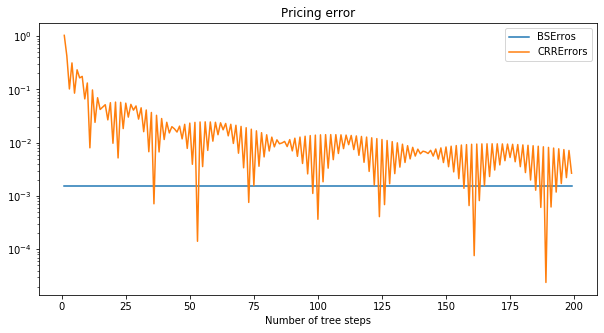

In [9]:
test_impB_Trees(100,1,105,200,ImpliedVol_flat)

When the implied volatility surface is used, the pricing error becomes larger for both models but converges into the smilar scale after $10^{-1}$ around 100 steps. Thus for the model setting, time steps should be at least 100. The larger error is expected as the negative skewness in the volatility smile. A constant volatility model is not expected to produce the same out of moeny option price with the price from a model with the smile. This plot test should confirm the tree is constructed correctly in principle, a more robust test will be carried out. 

bsPrice = 	  4.7360171267894735


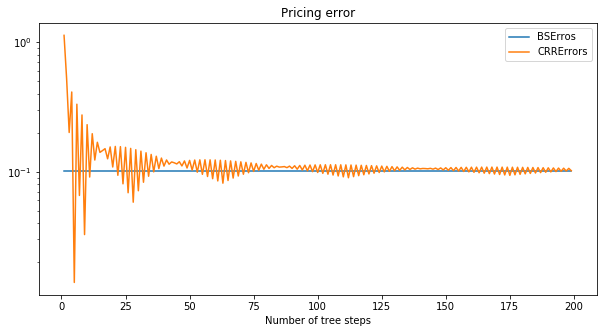

In [10]:
test_impB_Trees(100,1,105,200,ImpliedVol)

In [11]:
# Calibration function to test if the implied binomial tree calibrate to the implied volatility surface well.
def imbtCalibReport(S0, r, impliedVol,n):
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = -np.arange(0.9, 0., -0.1)
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_yticks(np.arange(len(ds)))
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, iv.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put) # ds[i]
            payoff = PayoffType.Put
            trade = EuropeanOption(T, K, payoff)
            vol = iv.Vol(ts[j], K)
            bs = bsPrice(S0, r, vol, T, K, payoff)
            # print("bsPrice = ", bs)
            ibt=impliedbinomialPricer(S0,r,impliedVol,vol,trade,n,additive_implied_Binomialtree)
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - ibt)/S0 * 10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    im = ax.imshow(err)
    ax.set_title("Implied Binomial Tree Pricing Error Matrix")
    fig.tight_layout()
    plt.show()

$\textbf{Calibration report}$

The calibration report function that loops over each point in dimensions of strike and time to maturity to produce the price with Black Scholes model, which can be regarded as market price and is used to compare the price from the implied binomial tree, for each point from volatility surface. If the implied binomial tree calibrates to the implied volatility surface well, the price it generates shouldn't deviate too much from market price. The x axis is time to maturity and y axis is delta for European put option. Errors are in basis points.

It can be noticed that prices of options with close to maturity and close to at the money have small errors, but for longer maturity, the errors become large especially at the top and down end. For longer maturity, far out of money or in the money options are not so actively traded, thus the intepolated implied volatility surface may not capture the skewness in the market so well. Moreover, the more time steps added, the longer the time to maturity, the more arbitrage node are generated by the implied binomial tree, as a result, without a robust overriding mechanism, the implied arbitrage can produce a distorted price.



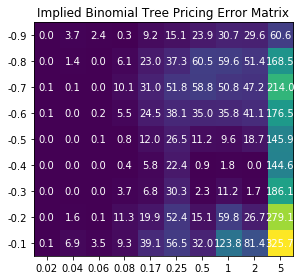

In [12]:
S0,r,q=100,0.04,0
iv=createTestImpliedVol(S0, r, q,ImpliedVol,None)
imbtCalibReport(S0, r, ImpliedVol,200)

The report below shows the error matrix for the prices produce by Black Scholes and implied binomial tree using the same constant volatility for each point. If use constant volatility, the correctly constructed implied binomial tree should be equal to a Black Scholes model. This test presents negligible pricing errors, which can be demostrated again that the implied binomial tree is implemented appropriately.

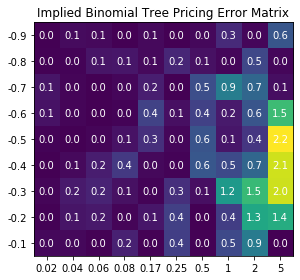

In [13]:
imbtCalibReport(S0, r, ImpliedVol_flat,200)

In [22]:
# Calibration report function to report error matrix of Greeks.
def imbtGreeksCalibReport(S0, r, impliedvol,n,greekType):
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = -np.arange(0.9, 0., -0.1)
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    plt.rcParams['figure.figsize']=[7,7]
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_yticks(np.arange(len(ds)))
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, iv.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put) # ds[i]
            payoff = PayoffType.Put
            trade = EuropeanOption(T, K, payoff)
            vol = iv.Vol(ts[j], K)
            bsgreek = BSgreeks(S0,r,vol,T,K,greekType,payoff)
            # print("bsPrice = ", bs)
            ibtgreek=impliedbinomialGreeks(S0, r, impliedvol, T,trade, n,greekType)
            # pde = pdePricer(S0, r, 0.0, 0.15, max(50, int(30 * T)), max(50, int(30 * T)), 0.5, trade)
            # print("pdePrice = ", pde)
            # zoom in error in basis point
            err[i, j] = math.fabs(bsgreek - ibtgreek)*10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    im = ax.imshow(err)
    ax.set_title("Implied Binomial Tree Greeks Error Matrix"+'-'+str(greekType))
    fig.tight_layout()
    plt.show()

In [15]:
# Black Scholes and implied binomial greeks functions
class greekType(Enum):
    Delta=0
    Gamma=1
    Theta=3
    Rho=4
    
def BSgreeks(S,r,vol,T,strike,greekType,payoffType):
    Delta=derivative(lambda x:bsPrice(x, r, vol, T, strike, payoffType),S,dx=0.01)
    Gamma=derivative(lambda x:bsPrice(x, r, vol, T, strike, payoffType),S,dx=0.01,n=2)
    Rho=derivative(lambda x:bsPrice(S, x, vol, T, strike, payoffType),r,dx=0.00001)
    greekDict={greekType.Delta:Delta,greekType.Gamma:Gamma,\
              greekType.Rho:Rho}
    return greekDict[greekType]
    

def impliedbinomialGreeks(S, r, impliedvol, T,trade, n,greekType) -> float:
   
    Delta=derivative(lambda x:impliedbinomialPricer(x, r, impliedvol,None, trade, n, additive_implied_Binomialtree),S,dx=10,n=1)
    Gamma=derivative(lambda x:impliedbinomialPricer(x, r, impliedvol,None, trade, n, additive_implied_Binomialtree),S,dx=10,n=2)  
#     Theta=-derivative(lambda x:impliedbinomialPricer(S, r, impliedvol,None,x, trade, n, additive_implied_Binomialtree),x,dx=0.1,n=1)
    Rho=derivative(lambda x:impliedbinomialPricer(S, x, impliedvol,None, trade, n, additive_implied_Binomialtree),r,dx=0.01,n=1)
    greekDict={greekType.Delta:Delta,greekType.Gamma:Gamma,\
              greekType.Rho:Rho}
    return greekDict[greekType]

$\textbf{Greeks test}$

Risk sensitivity is as important as pricing error for implementation of any pricing models. The delta and Gamma of European call option are specifically tested by ploting and calibration report. The ploting gives a unmatching delta and gamma profile from a typical European call option, despite they are very small in magnitude.

In [16]:
S0,r,q,T,n=100,0.04,0,1,150
imbtDelta=[]
imbtGamma=[]

for k in range(50,151):
        trade=EuropeanOption(S0,k,PayoffType.Call)
        imbtDelta.append(impliedbinomialGreeks(S0, r, ImpliedVol, T,trade, n,greekType.Delta))
        imbtGamma.append(impliedbinomialGreeks(S0, r, ImpliedVol, T,trade, n,greekType.Gamma))
        

x=[k for k in range(50,151)]


In [17]:
k=130
trade=EuropeanOption(S0,k,PayoffType.Call)
print(impliedbinomialGreeks(S0, r, ImpliedVol, T,trade, n,greekType.Delta))
print(impliedbinomialGreeks(S0, r, ImpliedVol, T,trade, n,greekType.Gamma))

0.9999999868666791
4.3956902118225114e-10


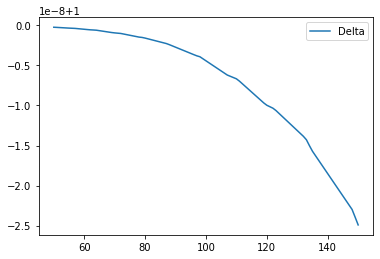

In [18]:
plt.plot(x,imbtDelta,label='Delta')
plt.legend()

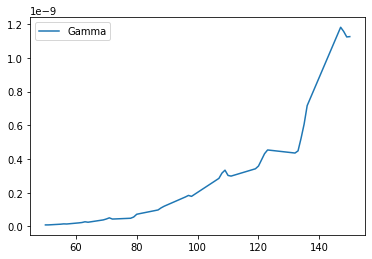

In [19]:
plt.plot(x,imbtGamma,label='Gamma')
plt.legend()

$\textbf{Greeks error matrix}$

Through examing the greeks error report of implied binomial tree, both delta and gamma of the implied binomial tree have very large discrepancies in basis points in both dimensions with that of Black Scholes. This makes the implied binomial tree very difficult to be applied to risk management.

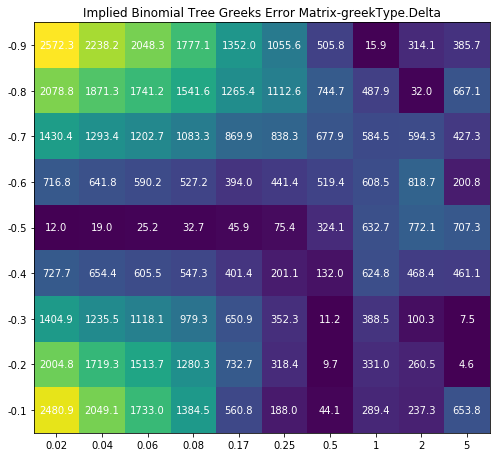

In [23]:
imbtGreeksCalibReport(S0, r, ImpliedVol,100,greekType.Delta)

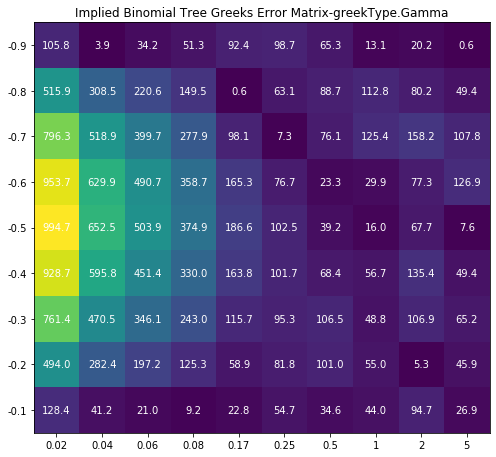

In [24]:
imbtGreeksCalibReport(S0, r, ImpliedVol,100,greekType.Gamma)

$\textbf{Part3: Application}$

The intention of the develoment of the implied binomial tree is to serve as a powerful tool to price non-actively traded derivatives, especially for barrier options whose probability of striking the barrier is sensitive to the shape of the smile. It is thus advisable to test barrier options pricing and knock in - knock out parity with the implied binomial tree with smile.

In [25]:
# test KI KO parity
class KnockInOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def triggerBarrier(self, t, S):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return True
            elif self.downBarrier != None and S < self.downBarrier:
                return True
        return False
    # for knock-in options we define two states,
    # first state is the option value if the knock-in is not triggered in previous steps
    # second state is the option value if the knock-in has been triggered
    # and we merged payoff function, if continuation is none then it's the last time step
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            notKnockedInTerminalValue = 0
            if self.triggerBarrier(t, S):  # if the trade is not knocked in,
                # it is still possible to knock in at the last time step
                notKnockedInTerminalValue = self.underlyingOption.payoff(S)
                # if the trade is knocked in already
            knockedInTerminalValue = self.underlyingOption.payoff(S)
            return [notKnockedInTerminalValue, knockedInTerminalValue]
        else:
            nodeValues = continuation
            # calculate state 0: if no hit at previous steps
            if self.triggerBarrier(t, S):
                nodeValues[0] = continuation[1]
            # otherwise just carrier the two continuation values
        return nodeValues
    
    
class KnockOutOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def payoff(self, S):
        return self.underlyingOption.payoff(S)
    def valueAtNode(self, t, S, continuation):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return 0
            elif self.downBarrier != None and S < self.downBarrier:
                return 0
        if continuation==None:
            return self.payoff(S)
        return continuation
    
# Modify impliedbinomialPricer to value knock in options
def impliedbinomialPricerX(S, r,impliedvol,exvol, trade, n, calib):
    t = trade.expiry / n
    (treeNode, p,_) = calib(S,t*n,n,r,impliedvol,exvol)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs=[trade.valueAtNode(trade.expiry, treeNode[-1][i], None) for i in range(n + 1)]
    numStates = np.size(vs[0])
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = treeNode[i][j]
            continuation = [math.exp(-r * t) * (vs[j][k] * p[i][j] + vs[j + 1][k] * (1 - p[i][j])) for k in range(numStates)]
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0][0]

def testKIKO():
    S, r, vol,n = 100, 0.01, 0.2,200
    opt = EuropeanOption(1, 105, PayoffType.Call)
    kiPrice = impliedbinomialPricerX(S, r, ImpliedVol,None, KnockInOption(90, 120, 0, 1, opt), n, additive_implied_Binomialtree)
    koPrice = impliedbinomialPricer(S, r, ImpliedVol,None, KnockOutOption(90, 120, 0, 1, opt), n, additive_implied_Binomialtree)
    euroPrice = impliedbinomialPricer(S, r, ImpliedVol,None, opt, n, additive_implied_Binomialtree)
    print("kiPrice = ", kiPrice)
    print("koPrice = ", koPrice)
    print("euroPrice = ", euroPrice)
    print("KIKO = ", kiPrice + koPrice)
    kis = [
        impliedbinomialPricerX(S, r, ImpliedVol,None, KnockInOption(90, 120, 0, 1, EuropeanOption(1, k, PayoffType.Call)), n, additive_implied_Binomialtree)
        for k in range(95, 115)]
    kos = [
        impliedbinomialPricer(S, r, ImpliedVol,None, KnockOutOption(90, 120, 0, 1, EuropeanOption(1, k, PayoffType.Call)), n, additive_implied_Binomialtree)
        for k in range(95, 115)]
    euros = [impliedbinomialPricer(S, r,  ImpliedVol,None, EuropeanOption(1, k, PayoffType.Call), n, additive_implied_Binomialtree) for k in range(95, 115)]
    kikos = [abs(kis[i] + kos[i] - euros[i]) for i in range(len(kis))]
    plt.plot(range(95, 115), kikos, label="KIKO - Euro")
    plt.legend();
    plt.xlabel('strike');
    plt.yscale('log')  # plot on log scale
    plt.show()

kiPrice =  0.4180040559145756
koPrice =  2.6286014317321467
euroPrice =  3.046605487646722
KIKO =  3.046605487646722


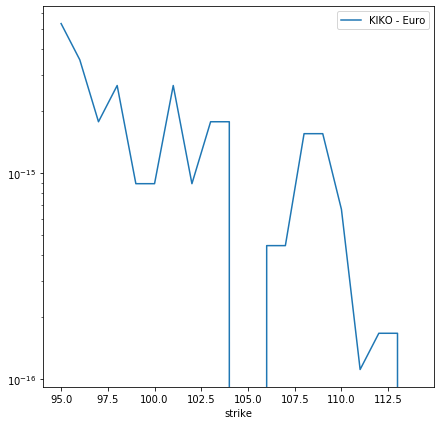

In [26]:
testKIKO()

$\textbf{KIKO test result}$

The result of KIKO test of implied binomial tree indicates the model value barrier options appropriately and KIKO parity is not violated. Moreover, while the error amplifies around central strike, the model seems to deliver lower KIKO error in magnitude generally than ordinary binomial trees. This result solidifies the model's usefulness in application of valuing barrier options or other derivatives that are sensititive to the shape of the volatility smile.

$\textbf{Part4: Limitation and Suggestions}$

As explained in the previous parts, the implied binomial tree is confirmed to be correctlly implemented. This model has its own advantage in pricing volatility smile sensititive products like barrier options and is very useful in pricing illquid derivatives while accommodating the smile. However, even though the construction of the tree is theoretical solid, there are nodes producing arbitrage prices, which somehow undermines the pricing ability, since the overriding rule is usually set arbitrarily. Furthermore, its greeks profile are very diffcult to tackle and hard to explain thus limits its usefulness in risk management or hedging. It is therefore advisable to develope more appopriate mechanism to overcome the arbitrage issue to further improve the implied binomial tree.
